# Women homicide analysis

By [Iris Lee](http://www.twitter.com/@irisslee)  
  
The Los Angeles Times [Homicide Report](https://homicide.latimes.com) conducted an analysis of female victims. It found: 

* The number of women being killed is increasing.
* Of the 295 women killed over past the three years, 75% of them are "cleared" - meaning suspect has been identified - by an investigating agency.  
* Of the 214 cleared cases, 170 cases had a suspect that knew the victim prior to killing.
* There were 99 cases where the suspect was in an intimate relationship with the victim.

These findings resulted in the September 19th story ["As homicides drop in L.A., more women are being killed — often by intimate partners"](https://www.latimes.com/projects/women-violence-homicides-increase-death-murder/).

### Configuration  

In [1]:
import os
import warnings
import pandas as pd
import altair as alt

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

### Download and read homicides  
Retrieves homicide list from the Times' unpublished API. This step had been withheld from the notebook to maintain our site's security.

In [5]:
homicides = pd.read_csv(os.getenv("HOMICIDE_REPORT_API"))

Separate out death year from death date

In [6]:
homicides["death date"] = pd.to_datetime(homicides['death date'])

In [7]:
homicides['death_year'] = homicides['death date'].dt.year

Separate out 10 years

In [8]:
h10 = homicides[homicides["death_year"].isin(list(range(2008,2019)))]

In [9]:
h10.head(1)

,ID,coroners case number,police case number,da case number,slug,first name,middle name,last name,suffix,death date,death time,age,date of birth,cause,security hold,Have autopsy?,gender,race,died on scene,sequela,incident address,incident zipcode,officer involved,ruling,coroners description,synopsis,incident point x,incident point y,neighborhoodv6__name,jurisdiction__name,image,death_year
365,16949,2018-09898,018-19377-0459-011,NaN,jose-carlos-soto-jr,Jose,Carlos,Soto,Jr.,2018-12-31,17:06:00,26.0,1992-03-03,gunshot,False,False,male,latino,True,False,14300 block of Carmenita Road,90650.0,False,H,GUNSHOT WOUNDS OF THE CHEST 26Y/O MALE WAS ...,NaN,-118.046626,33.901736,Norwalk,LASD Homicide,NaN,2018


In [10]:
h10.groupby('death_year').size().sum()

7505

Separate out victims with gender listed 

In [11]:
with_gender = h10[h10.gender.isin(['male','female'])]

In [12]:
with_gender.gender.value_counts()

male      6395
female    1096
Name: gender, dtype: int64

In [13]:
with_gender.gender.value_counts('normalize')

male      0.853691
female    0.146309
Name: gender, dtype: float64

In [14]:
with_gender.groupby(['death_year', 'gender']).size().unstack(level=-1)

gender,female,male
death_year,,
2008,131,755
2009,108,660
2010,121,568
2011,96,548
2012,89,567
2013,76,546
2014,82,503
2015,98,566
2016,87,609


How has number of homicide victims change over the years?

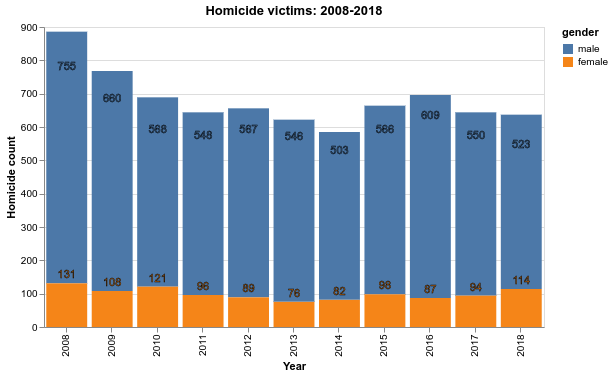

In [15]:
ten = alt.Chart(with_gender, title="Homicide victims: 2008-2018").mark_bar().encode(
        x=alt.X('death_year:O', axis = alt.Axis(title = "Year")),
        y = alt.Y('count(ID)', axis = alt.Axis(title = "Homicide count")),
        color= alt.Color('gender:N',sort=alt.SortOrder('descending')),
        order = alt.Order('gender', sort='ascending')
    ).properties(width = 500)

text = ten.mark_text(
        align = 'center',
        stroke = 'black',
        strokeWidth = 0.5,
        dy= -5
    ).encode(text ='count(ID)')

ten + text

=> **While fewer and fewer young men are being killed on the streets of LA, the number of female victims has increased.** 

Women homicides only from 2016-2018

In [16]:
_1618 = with_gender[(with_gender.gender == 'female') & (with_gender.death_year.isin([2016,2017,2018]))]

In [17]:
_1618.ID.nunique()

295

=> **In the past three years, 295 women were killed across the county**

### Review the police investigation of all 295 female victims

The Times then reviewed the outcome of the police investigation for all female victims from 2016 to 2018.

We confirmed the following through records requests and interviews with the investigating agencies. 
1. Is the case being investigated by law enforcement?  
2. What is the status of the investigation?  
3. For "cleared" cases - the ones where the suspect is known to law enforcement - what was the suspect-victim relationship?

The data is not be published with this notebook to avoid airing sensitive and potentially inaccurate information that was not fit for inclusion in our story.

In [18]:
victims =  pd.read_csv('victims.csv')

Separate out the death year

In [19]:
victims["death date"] = pd.to_datetime(victims['death date'])

In [20]:
victims['death_year'] = victims["death date"].dt.year

In [21]:
len(victims)

295

Verify our row count matches the homicide report database

In [22]:
assert len(victims) == len(_1618) 

In [23]:
assert victims['coroners case number'].isin(_1618['coroners case number']).all()

From the victims reviewed, we filtered out the ones law enforcement did not pursue (accidents, sequela..etc ).


In [24]:
# c = cleared
# U = open investigation
cases = victims[victims.cleared.isin(['c','U'])]

In [25]:
len(cases)

291

=> **The police investigated 291 cases from 2016-2018**

In [26]:
cases.cleared.value_counts()

c    214
U     77
Name: cleared, dtype: int64

In [27]:
cases.cleared.value_counts('normalize')

c    0.735395
U    0.264605
Name: cleared, dtype: float64

Filter out only cleared cases where law enforcement have a suspect in mind.

In [28]:
cleared = cases[cases.cleared == 'c']

In [29]:
len(cleared)/len(cases)

0.7353951890034365

=> **Nearly 3 out of 4 cases, the police have names a suspect (74%)**

In [30]:
cleared['suspect_knew_victim'].value_counts('normalize')

Y    0.794393
N    0.205607
Name: suspect_knew_victim, dtype: float64

In [31]:
cleared['suspect_knew_victim'].value_counts()

Y    170
N     44
Name: suspect_knew_victim, dtype: int64

=> **The review found that in cases where police have named the suspect, the vast majority of accused killers knew their victim.**

Separate out intimate relationships. List all determined 

In [32]:
cleared["suspect_relationship"].value_counts()

husband                   46
boyfriend                 23
ex-boyfriend              21
son                       11
OIS                        8
acquaintance               7
friend                     6
partner                    6
father                     5
mother                     4
roomate                    4
mother's ex-boyfriend      3
ex-husband                 3
caregiver                  3
granddaughter              2
nephew                     2
client                     2
brother                    2
great granddaughter        1
gang                       1
parents' co-worker         1
daughter's boyfriend       1
son's friend               1
friend's ex-husband        1
friend's brother           1
stepsister's boyfriend     1
son-in-law                 1
sister's ex-boyfriend      1
renter on property         1
tenant's niece             1
mother's boyfriend         1
grandson                   1
daughter's ex              1
sister's boyfriend         1
caregiver's so

In [33]:
intimate_relationships = ['husband', 'boyfriend', 'ex-boyfriend', 'ex-husband','partner']

In [34]:
intimate_homicides = cleared[cleared['suspect_relationship'].isin(intimate_relationships)]

In [35]:
len(intimate_homicides)

99

In [36]:
len(intimate_homicides)/len(cleared)

0.46261682242990654

=> **Nearly half were, at some point, in an intimate relationship; husbands, boyfriends and, often, exes.(46%)**

In [37]:
intimate_homicides.head(1)

,coroners case number,first name,middle name,last name,death date,age,cause,race,notes,cleared,suspect_knew_victim,suspect_relationship,coverage,death_year
3,2017-02882,Alexiz,Miranda,Orona,2017-04-14,18,gunshot,latino,boyfriend +3 more suspects,c,Y,boyfriend,NaN,2017.0


In [38]:
intimate_homicides.death_year.value_counts()

2017.0    40
2018.0    34
2016.0    25
Name: death_year, dtype: int64

Create column to mark intimate partners

In [39]:
cases['ip'] = cases['suspect_relationship'].isin(intimate_relationships)

In [40]:
cases.groupby('death_year')['suspect_knew_victim'].value_counts('normalize')

death_year  suspect_knew_victim
2016.0      Y                      0.738462
            N                      0.261538
2017.0      Y                      0.842857
            N                      0.157143
2018.0      Y                      0.807692
            N                      0.192308
Name: suspect_knew_victim, dtype: float64

**CAUSES**

In [41]:
cases.cause.value_counts('normalize')

gunshot        0.591696
stabbing       0.169550
blunt-force    0.124567
other          0.055363
strangled      0.038062
pending        0.020761
Name: cause, dtype: float64

In [42]:
cases[cases.ip == True].cause.value_counts('normalize')

gunshot        0.632653
stabbing       0.214286
blunt-force    0.081633
strangled      0.040816
other          0.030612
Name: cause, dtype: float64

**RACE**

In [43]:
cases.race.value_counts('normalize')

latino    0.440972
black     0.250000
white     0.225694
asian     0.079861
other     0.003472
Name: race, dtype: float64

In [44]:
cases[cases.ip == True].race.value_counts('normalize')

latino    0.443299
white     0.309278
black     0.164948
asian     0.082474
Name: race, dtype: float64

**AGE**

In [45]:
cases.age.median()

35.0

In [46]:
cases[cases.ip == True].age.median()

35.0

### Causes and age among male victims vs. female victims from 2016 to 2018

In [47]:
men_1618 = with_gender[(with_gender.gender == 'male') & (with_gender.death_year.isin([2016,2017,2018]))]

In [48]:
men_1618.cause.value_counts('normalize')

gunshot         0.769185
stabbing        0.104105
blunt-force     0.078525
other           0.033314
pending         0.007139
strangled       0.005354
undetermined    0.002380
Name: cause, dtype: float64

In [49]:
men_1618.age.median()

31.0

### Income levels in incident neighborhoods 

Merge case information with previous API pull for complete information

In [50]:
cases_detailed = pd.merge(cases, _1618, on='coroners case number', how='inner')

In [51]:
len(cases_detailed)

291

What are top neighborhoods where homicide occurs

In [52]:
cases_detailed['neighborhoodv6__name'].value_counts().head(6).index.tolist()

['Long Beach', 'Inglewood', 'Westlake', 'Compton', 'Carson', 'Hawthorne']

Read median income file

In [60]:
income = pd.read_csv('2017_income.csv')

In [61]:
len(income)

270

Median income for L.A. County is $61,015 per [U.S. Census]('https://www.census.gov/quickfacts/losangelescountycalifornia')

Neighborhoods below median income level

In [62]:
below = income[income.median_income < 61015].neighborhood.tolist()

In [63]:
len(below)

113

Neighborhoods above median income level

In [64]:
above = income[income.median_income > 61015].neighborhood.tolist()

In [65]:
len(above)

157

how many victims' neighborhood is from ones below median?

In [66]:
len(cases_detailed[cases_detailed['neighborhoodv6__name'].isin(below)])

190

how many victims' neighborhood from ones above median income

In [67]:
len(cases_detailed[cases_detailed['neighborhoodv6__name'].isin(above)])

89

How many with missing neighborhoods?

In [68]:
len(cases_detailed)-(len(cases_detailed[cases_detailed['neighborhoodv6__name'].isin(below)])+len(cases_detailed[cases_detailed['neighborhoodv6__name'].isin(above)]))

12

In [69]:
(190)/(291-12)

0.6810035842293907

=> **70% victims died in neighborhoods with median income lower than county's median**

Compare male victims

In [70]:
len(men_1618[men_1618['neighborhoodv6__name'].isin(below)])/len(men_1618)

0.7829964328180737

### Create a dataset ready for visualization

Modify dataframe for visualization

In [71]:
viz = cases.copy()

In [72]:
cases.head(1)

,coroners case number,first name,middle name,last name,death date,age,cause,race,notes,cleared,suspect_knew_victim,suspect_relationship,coverage,death_year,ip
0,2018-05087,Abril,NaN,Onofre,2018-07-05,19,gunshot,latino,NaN,U,NaN,NaN,https://homicide.latimes.com/post/abril-onofre/,2018.0,False


In [73]:
#Mark open investigation
viz.loc[viz.cleared=='U', 'status'] = 'open'
#Mark ones with arrest but suspect is random to victim
viz.loc[((viz.cleared=='c')& ~(viz['suspect_knew_victim'] == 'Y')), 'status'] = 'random_suspect'
#Mark ones with arrest and suspect is known to victim 
viz.loc[((viz.cleared=='c')&(viz['suspect_knew_victim'] == 'Y')), 'status'] = 'familiar_suspect'
#mark ones with arresta and suspect is romantic
viz.loc[((viz.cleared=='c')&(viz['ip'] == True)), 'status'] = 'intimate_partner'

In [74]:
trimmed_viz = viz.rename(columns={'last name':'last_name','death date':'death_date' })

In [75]:
trimmed_viz = trimmed_viz[[
    'last_name',
    'death_date',
    'age',
    'cause',
    'race',
    'status'
]]

In [76]:
trimmed_viz.to_csv("women.csv", index=False)